In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import folium
from folium.plugins import MarkerCluster
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('after_merge.csv')
df

,Unnamed: 0,SKU,STORE,COST,RETAIL,REGISTER,TRANNUM,SEQ,SALEDATE,STYPE,QUANTITY,ORGPRICE,SPRICE,AMT,INTERID,MIC,CITY,STATE,ZIP
0,0,3,4603,123.36,440.0,100,1200,0,2005-04-12,R,1,440.00,30.00,30.00,3400000,333,CORALVILLE,IA,52241
1,1,6819,4603,4.00,2.5,470,1600,0,2005-07-23,P,1,9.99,2.00,2.00,139000038,87,CORALVILLE,IA,52241
2,2,9633,4603,13.50,22.5,280,1200,0,2004-11-03,P,1,21.00,21.00,21.00,512500049,281,CORALVILLE,IA,52241
3,3,10896,4603,11.10,18.5,390,1900,0,2004-09-01,P,1,18.50,18.50,18.50,521400008,281,CORALVILLE,IA,52241
4,4,17379,4603,24.03,16.0,500,1800,0,2005-07-07,P,1,64.00,16.00,16.00,526900029,689,CORALVILLE,IA,52241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134482,1134482,9888223,7604,9.32,16.0,340,1000,670805443,2005-08-20,P,1,32.00,16.00,16.00,509400085,697,RICHMOND,VA,23233
1134483,1134483,9928678,7604,7.25,4.5,70,5900,0,2005-08-20,P,1,18.00,4.50,4.50,189400107,810,RICHMOND,VA,23233
1134484,1134484,9957390,7604,17.10,28.5,770,200,0,2005-08-06,P,1,28.50,28.50,28.50,581500061,643,RICHMOND,VA,23233
1134485,1134485,9979437,7604,148.50,134.3,350,600,941208922,2005-08-23,P,1,395.00,94.01,94.01,77600063,983,RICHMOND,VA,23233


In [3]:
# Assuming your DataFrame is named df
# Convert SALEDATE to datetime
df['SALEDATE'] = pd.to_datetime(df['SALEDATE'])

# Inventory Turnover
df['InventoryTurnover'] = df['COST'] / df['QUANTITY']

# Gross Profit
df['GrossProfit'] = df['RETAIL'] - (df['COST'] * df['QUANTITY'])

# Year-over-Year (YoY) Growth
df['YoYGrowth'] = df.groupby('SKU')['AMT'].pct_change(12) * 100

# Return Percentage by SKU
df['ReturnPercentage'] = (df['ORGPRICE'] - df['SPRICE']) / df['ORGPRICE'] * 100

# Average Spend by Store
avg_spend_by_store = df.groupby('STORE')['AMT'].mean()

# Display results
print("Inventory Turnover:")
print(df['InventoryTurnover'].head())

print("\nGross Profit:")
print(df['GrossProfit'].head())

print("\nYoY Growth:")
print(df['YoYGrowth'].head())

print("\nReturn Percentage by SKU:")
print(df['ReturnPercentage'].head())

print("\nAverage Spend by Store:")
print(avg_spend_by_store.head())


Inventory Turnover:
0    123.36
1      4.00
2     13.50
3     11.10
4     24.03
Name: InventoryTurnover, dtype: float64

Gross Profit:
0    316.64
1     -1.50
2      9.00
3      7.40
4     -8.03
Name: GrossProfit, dtype: float64

YoY Growth:
0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
Name: YoYGrowth, dtype: float64

Return Percentage by SKU:
0    93.181818
1    79.979980
2     0.000000
3     0.000000
4    75.000000
Name: ReturnPercentage, dtype: float64

Average Spend by Store:
STORE
102    29.375504
103    26.651302
107    27.926380
202    23.023719
203    25.629025
Name: AMT, dtype: float64


In [4]:
df['SALEDATE'] = pd.to_datetime(df['SALEDATE'])

# Create a new column for the year
df['Year'] = df['SALEDATE'].dt.year

# Calculate YoY Total Sales by Store
df['YoYTotalSales'] = df.groupby(['Year', 'STORE'])['RETAIL'].transform('sum')

# Calculate YoY Percentage Increase
df['YoYPercentageIncrease'] = df.groupby('STORE')['YoYTotalSales'].pct_change() * 100

total_sales_returns = df.groupby(['STORE', 'STYPE'])['AMT'].sum().unstack(fill_value=0)

# Calculate the percentage of returns for each store
total_sales_returns['ReturnPercentage'] = (total_sales_returns['R'] / (total_sales_returns['P'] + total_sales_returns['R'])) * 100

# Merge the results back to the original DataFrame
df = df.merge(total_sales_returns['ReturnPercentage'].reset_index(), on='STORE', how='left')
df

,Unnamed: 0,SKU,STORE,COST,RETAIL,REGISTER,TRANNUM,SEQ,SALEDATE,STYPE,QUANTITY,ORGPRICE,SPRICE,AMT,INTERID,MIC,CITY,STATE,ZIP,InventoryTurnover,GrossProfit,YoYGrowth,ReturnPercentage_x,Year,YoYTotalSales,YoYPercentageIncrease,ReturnPercentage_y
0,0,3,4603,123.36,440.0,100,1200,0,2005-04-12,R,1,440.00,30.00,30.00,3400000,333,CORALVILLE,IA,52241,123.36,316.64,NaN,93.181818,2005,34497.61,NaN,11.655572
1,1,6819,4603,4.00,2.5,470,1600,0,2005-07-23,P,1,9.99,2.00,2.00,139000038,87,CORALVILLE,IA,52241,4.00,-1.50,NaN,79.979980,2005,34497.61,0.000000,11.655572
2,2,9633,4603,13.50,22.5,280,1200,0,2004-11-03,P,1,21.00,21.00,21.00,512500049,281,CORALVILLE,IA,52241,13.50,9.00,NaN,0.000000,2004,9425.85,-72.676803,11.655572
3,3,10896,4603,11.10,18.5,390,1900,0,2004-09-01,P,1,18.50,18.50,18.50,521400008,281,CORALVILLE,IA,52241,11.10,7.40,NaN,0.000000,2004,9425.85,0.000000,11.655572
4,4,17379,4603,24.03,16.0,500,1800,0,2005-07-07,P,1,64.00,16.00,16.00,526900029,689,CORALVILLE,IA,52241,24.03,-8.03,NaN,75.000000,2005,34497.61,265.989380,11.655572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1134482,1134482,9888223,7604,9.32,16.0,340,1000,670805443,2005-08-20,P,1,32.00,16.00,16.00,509400085,697,RICHMOND,VA,23233,9.32,6.68,NaN,50.000000,2005,9000.48,0.000000,11.894831
1134483,1134483,9928678,7604,7.25,4.5,70,5900,0,2005-08-20,P,1,18.00,4.50,4.50,189400107,810,RICHMOND,VA,23233,7.25,-2.75,NaN,75.000000,2005,9000.48,0.000000,11.894831
1134484,1134484,9957390,7604,17.10,28.5,770,200,0,2005-08-06,P,1,28.50,28.50,28.50,581500061,643,RICHMOND,VA,23233,17.10,11.40,0.0,0.000000,2005,9000.48,0.000000,11.894831
1134485,1134485,9979437,7604,148.50,134.3,350,600,941208922,2005-08-23,P,1,395.00,94.01,94.01,77600063,983,RICHMOND,VA,23233,148.50,-14.20,NaN,76.200000,2005,9000.48,0.000000,11.894831


In [5]:
#from sklearn.preprocessing import LabelEncoder
#label_encoder = LabelEncoder()
#df['CITY'] = label_encoder.fit_transform(df['CITY'])
#df

In [6]:
df2 = df.groupby('STORE')[['InventoryTurnover', 'GrossProfit', 'ReturnPercentage_y']].mean()
df2['success'] = ((df2['InventoryTurnover'] > df2['InventoryTurnover'].quantile(0.50)) &
                  (df2['GrossProfit'] > df2['GrossProfit'].quantile(0.50)) &
                  (df2['ReturnPercentage_y'] > df2['ReturnPercentage_y'].quantile(0.05))).astype(int)

df2['CITY'] = df.groupby('STORE')['CITY'].first().values
df2.reset_index(inplace=True)  # Reset the index to make 'STORE' a regular column
df2 = df2[['STORE', 'CITY', 'InventoryTurnover', 'GrossProfit', 'ReturnPercentage_y', 'success']]
df2

,STORE,CITY,InventoryTurnover,GrossProfit,ReturnPercentage_y,success
0,102,TAMPA,17.663513,6.073868,9.726143,1
1,103,ST LOUIS,16.089679,6.849022,10.602569,1
2,107,HURST,16.287056,7.251869,10.331423,1
3,202,TAMPA,14.711616,4.641666,10.407317,0
4,203,CHESTERFIELD,15.545438,5.673788,12.336764,1
...,...,...,...,...,...,...
320,9704,SHAWNEE,12.332212,6.332404,7.494701,0
321,9709,GREELEY,12.938681,4.194834,9.260292,0
322,9804,LAWTON,14.676519,7.659122,10.521946,0
323,9806,MABELVALE,17.165040,13.592576,4.027118,0


In [7]:
df2['success'].value_counts()

0    239
1     86
Name: success, dtype: int64

## Data Visualization

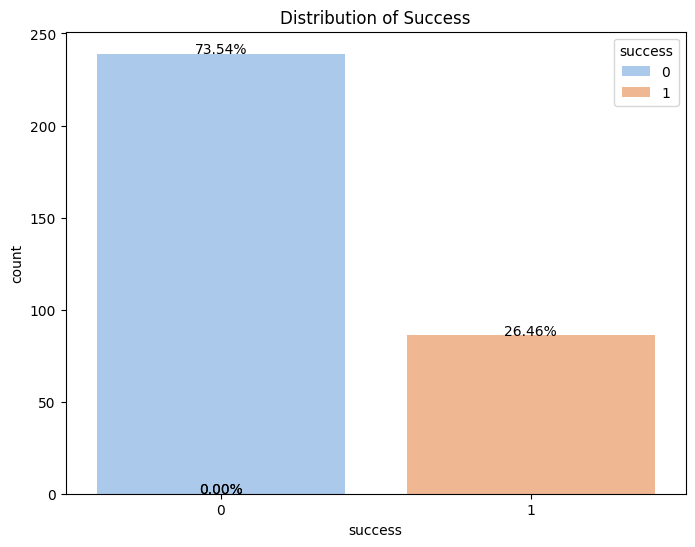

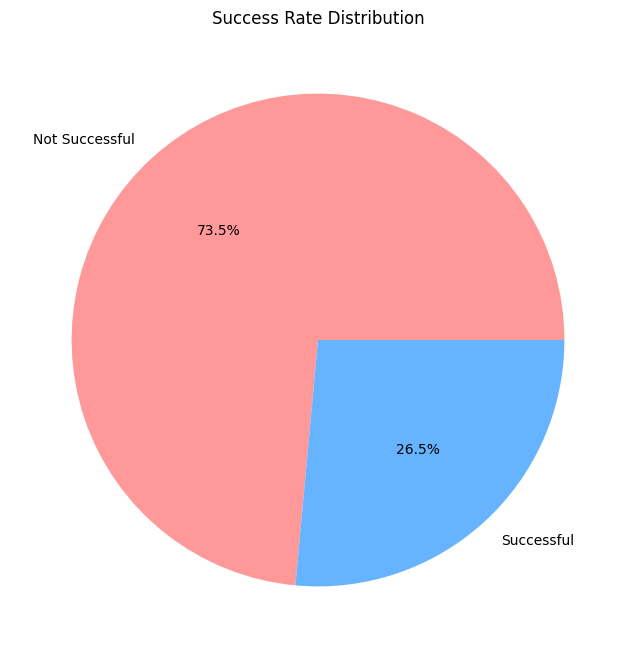

In [8]:
# Set the color palette
sns.set_palette("pastel")

# Explore distribution of 'success' variable with different colors
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='success', data=df2, hue='success')

# Add percentage labels
total = float(len(df2))
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1, '{:.2%}'.format(height/total), ha="center")

plt.title('Distribution of Success')
plt.show()




# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(df2['success'].value_counts(), labels=['Not Successful', 'Successful'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])

# Add title
plt.title('Success Rate Distribution')

plt.show()


/var/folders/cq/gb8md3g17dx_n11dzhh41nbr0000gp/T/ipykernel_58633/3581071655.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df2.corr()


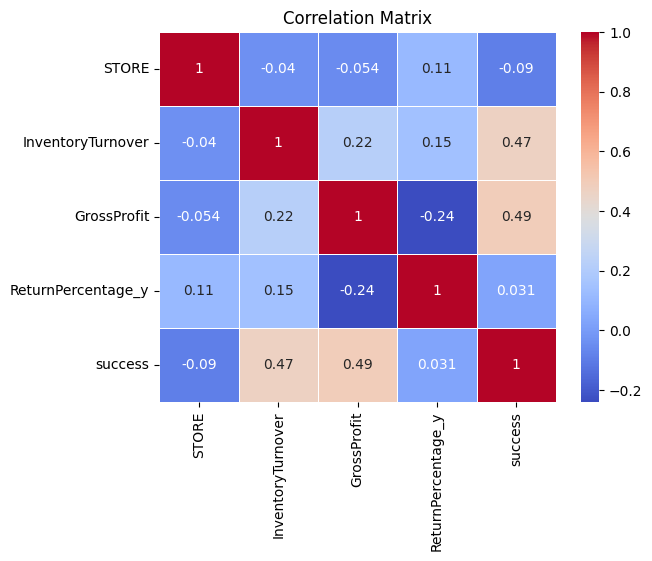

In [9]:
# Visualize the correlation matrix
corr_matrix = df2.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

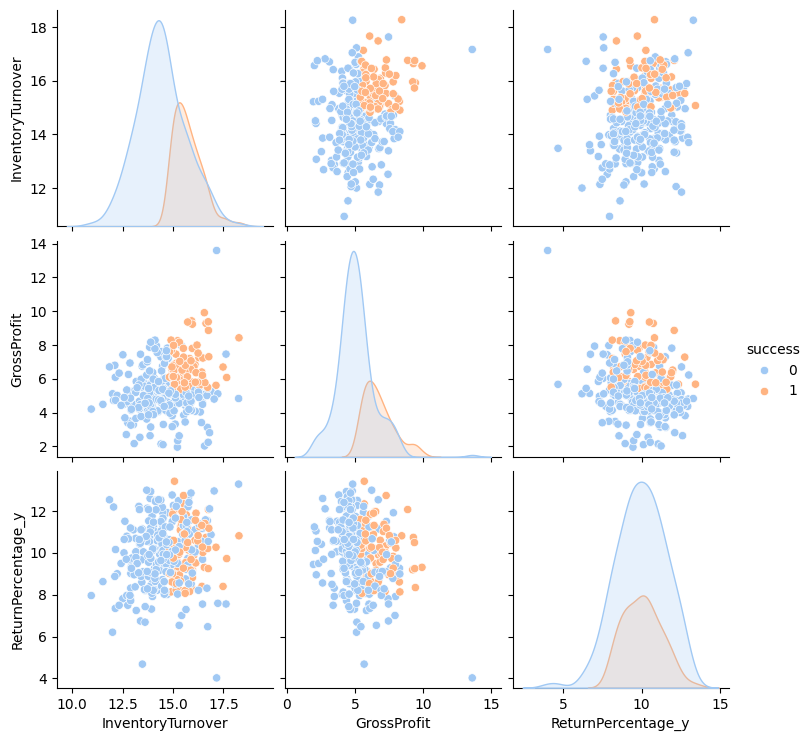

In [10]:
# Pairplot for selected features
sns.pairplot(df2[['InventoryTurnover', 'GrossProfit', 'ReturnPercentage_y', 'success']], hue='success', diag_kind='kde')
plt.show()

## Data Engineering

In [11]:
geolocator = Nominatim(user_agent="my_geocoder")
unique_cities_df = pd.DataFrame(df['CITY'].unique(), columns=['CITY'])

def get_lat_long(city):
    location = geolocator.geocode(city)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None
    
unique_cities_df['LATITUDE'], unique_cities_df['LONGITUDE'] = zip(*unique_cities_df['CITY'].apply(get_lat_long))
df2 = pd.merge(df2, unique_cities_df, on='CITY', how='left')

df2 = df2.drop('CITY', axis=1)
df2

,STORE,InventoryTurnover,GrossProfit,ReturnPercentage_y,success,LATITUDE,LONGITUDE
0,102,17.663513,6.073868,9.726143,1,27.947760,-82.458444
1,103,16.089679,6.849022,10.602569,1,38.628028,-90.191015
2,107,16.287056,7.251869,10.331423,1,32.823462,-97.170568
3,202,14.711616,4.641666,10.407317,0,27.947760,-82.458444
4,203,15.545438,5.673788,12.336764,1,37.385998,-77.578509
...,...,...,...,...,...,...,...
320,9704,12.332212,6.332404,7.494701,0,39.027368,-95.762754
321,9709,12.938681,4.194834,9.260292,0,38.457036,-101.818501
322,9804,14.676519,7.659122,10.521946,0,34.608685,-98.390331
323,9806,17.165040,13.592576,4.027118,0,34.655093,-92.386543


In [12]:
from sklearn.preprocessing import StandardScaler

# Create interaction features
df2['Interaction1'] = df2['InventoryTurnover'] * df2['GrossProfit']
df2.fillna(df2.mean(), inplace=True)

# Standardize numerical features
scaler = StandardScaler()
df2[['InventoryTurnover', 'GrossProfit', 'ReturnPercentage_y', 'Interaction1']] = scaler.fit_transform(df2[['InventoryTurnover', 'GrossProfit', 'ReturnPercentage_y', 'Interaction1']])

# Reorder the columns
df2 = df2[['STORE', 'InventoryTurnover', 'GrossProfit', 'ReturnPercentage_y', 'LATITUDE', 'LONGITUDE', 'Interaction1', 'success']]

# Display the updated DataFrame
df2


,STORE,InventoryTurnover,GrossProfit,ReturnPercentage_y,LATITUDE,LONGITUDE,Interaction1,success
0,102,2.353090,0.380613,-0.164229,27.947760,-82.458444,1.019423,1
1,103,1.081006,0.899171,0.423264,38.628028,-90.191015,1.135116,1
2,107,1.240540,1.168665,0.241507,32.823462,-97.170568,1.449421,1
3,202,-0.032841,-0.577493,0.292381,27.947760,-82.458444,-0.529634,0
4,203,0.641112,0.112970,1.585743,37.385998,-77.578509,0.261393,1
...,...,...,...,...,...,...,...,...
320,9704,-1.956044,0.553567,-1.660026,39.027368,-95.762754,-0.140135,0
321,9709,-1.465853,-0.876412,-0.476502,38.457036,-101.818501,-1.086143,0
322,9804,-0.061210,1.441106,0.369220,34.608685,-98.390331,1.222924,0
323,9806,1.950189,5.410432,-3.984443,34.655093,-92.386543,6.025382,0


In [13]:
# Create a Folium map centered around the first store's coordinates
m = folium.Map(location=[27.947760, -82.458444], zoom_start=5)

# Create MarkerClusters for success and failure
success_cluster = MarkerCluster(name='Success')
failure_cluster = MarkerCluster(name='Failure')

# Iterate through the DataFrame and add markers to the clusters
for index, data in df2.iterrows():
    lat, lon = data['LATITUDE'], data['LONGITUDE']
    success = data['success']
    store = data['STORE']  # Replace 'store' with 'data['STORE']'

    # Choose marker color based on success
    color = 'green' if success == 1 else 'red'

    # Create a marker
    marker = folium.Marker(location=[lat, lon], popup=f'Store: {store}', icon=folium.Icon(color=color))

    # Add marker to appropriate cluster
    if success == 1:
        marker.add_to(success_cluster)
    else:
        marker.add_to(failure_cluster)

# Add clusters to the map
success_cluster.add_to(m)
failure_cluster.add_to(m)

# Add a LayerControl to toggle between Success and Failure clusters
folium.LayerControl().add_to(m)

# Save the map as an HTML file or display it
# m.save('store_success_map.html')
m

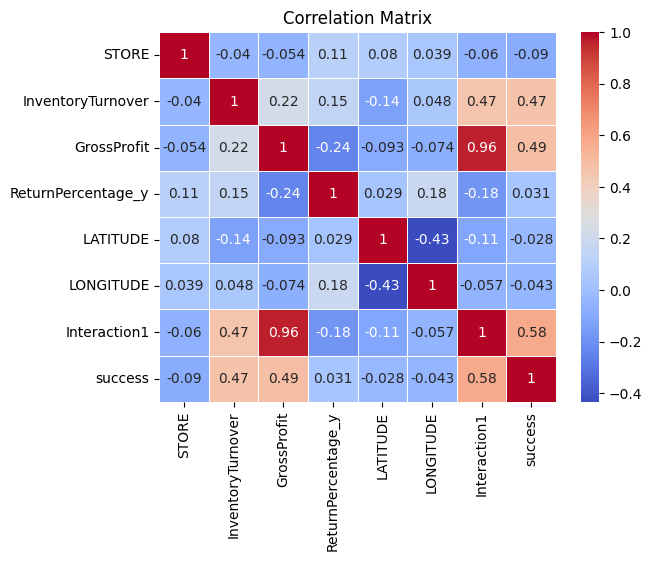

In [14]:
# Visualize the correlation matrix
corr_matrix = df2.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

## Model Evaluation

Use Smote for imbalanced dataset.

In [15]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Assuming df2 is your DataFrame
X = df2[['InventoryTurnover', 'GrossProfit', 'ReturnPercentage_y', 'Interaction1', 'LATITUDE', 'LONGITUDE']]
y = df2['success']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use SMOTE to oversample the minority class in the training set only
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Before SMOTE
print("Class distribution before SMOTE:")
print(y_train.value_counts())

# After SMOTE
print("\nClass distribution after SMOTE:")
print(y_train_resampled.value_counts())

#Before SMOTE
print("Number of samples in X_train:", X_train.shape[0])
print("Number of samples in X_train after SMOTE:", X_train_resampled.shape[0])

#After SMOTE
print("Number of samples in y_train:", y_train.shape[0])
print("Number of samples in y_train after SMOTE:", y_train_resampled.shape[0])

print("Number of samples in X_test:", X_test.shape[0])
print("Number of samples in y_test:", y_test.shape[0])

Class distribution before SMOTE:
0    189
1     71
Name: success, dtype: int64

Class distribution after SMOTE:
0    189
1    189
Name: success, dtype: int64
Number of samples in X_train: 260
Number of samples in X_train after SMOTE: 378
Number of samples in y_train: 260
Number of samples in y_train after SMOTE: 378
Number of samples in X_test: 65
Number of samples in y_test: 65


## Logistic Regression Model

In [16]:
import statsmodels.api as sm

# Add a constant to the features for the intercept term
X_train_resampled_with_const = sm.add_constant(X_train_resampled)

# Create a Logistic Regression model using statsmodels
logit_model_stats = sm.Logit(y_train_resampled, X_train_resampled_with_const)

# Fit the model
logit_result = logit_model_stats.fit()

# Display the summary
print(logit_result.summary())


Optimization terminated successfully.
         Current function value: 0.337486
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                  378
Model:                          Logit   Df Residuals:                      371
Method:                           MLE   Df Model:                            6
Date:                Fri, 24 Nov 2023   Pseudo R-squ.:                  0.5131
Time:                        13:17:35   Log-Likelihood:                -127.57
converged:                       True   LL-Null:                       -262.01
Covariance Type:            nonrobust   LLR p-value:                 3.767e-55
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.6083      0.903     -1.780      0.075      -3.379       0.162
Inven

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Create a Logistic Regression model
logit_model = LogisticRegression(random_state=42)

# Fit the model on the resampled training set
logit_model.fit(X_train_resampled, y_train_resampled)

# Predictions on the original test set
y_pred = logit_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

logit_model.score(X_train_resampled, y_train_resampled), logit_model.score(X_test, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        50
           1       0.69      0.73      0.71        15

    accuracy                           0.86        65
   macro avg       0.80      0.82      0.81        65
weighted avg       0.87      0.86      0.86        65



(0.8783068783068783, 0.8615384615384616)

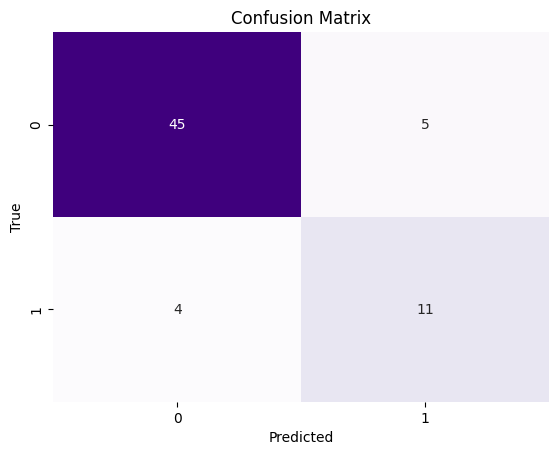

In [18]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression Hyperparameters

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


# Create a pipeline for logistic regression
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Standardize features
    ('logreg', LogisticRegression())  # Logistic Regression model
])

# Define hyperparameters for logistic regression
logreg_params = {'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# Perform grid search for logistic regression
logreg_grid = GridSearchCV(logreg_pipeline, logreg_params, cv=5)
logreg_grid.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters for logistic regression
print("Best Hyperparameters for Logistic Regression:", logreg_grid.best_params_)

# Make predictions on the test set using the best logistic regression model
y_pred_logreg = logreg_grid.predict(X_test)

# Evaluate the logistic regression model
print("\nAccuracy Score (Logistic Regression):")
print(accuracy_score(y_test, y_pred_logreg))

print("\nClassification Report (Logistic Regression):")
print(classification_report(y_test, y_pred_logreg))

logit_model.score(X_train_resampled, y_train_resampled), logit_model.score(X_test, y_test)

Best Hyperparameters for Logistic Regression: {'logreg__C': 100}

Accuracy Score (Logistic Regression):
0.8769230769230769

Classification Report (Logistic Regression):
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        50
           1       0.73      0.73      0.73        15

    accuracy                           0.88        65
   macro avg       0.83      0.83      0.83        65
weighted avg       0.88      0.88      0.88        65



(0.8783068783068783, 0.8615384615384616)

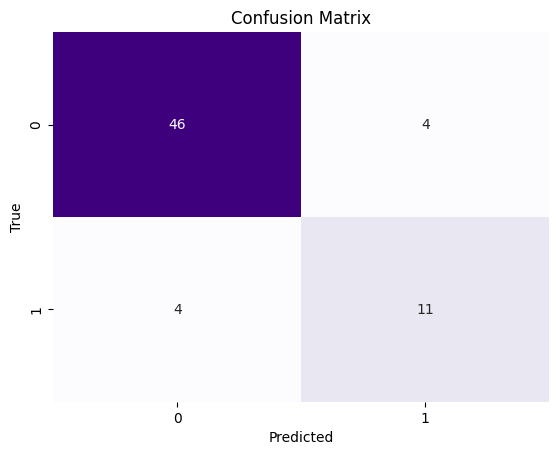

In [20]:
cm = confusion_matrix(y_test, y_pred_logreg)
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Decision Tree

In [21]:
from sklearn.tree import DecisionTreeClassifier

decision_tree_model = DecisionTreeClassifier(random_state=42)
decision_tree_model.fit(X_train_resampled, y_train_resampled)
y_pred_dt = decision_tree_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

decision_tree_model.score(X_train_resampled, y_train_resampled), decision_tree_model.score(X_test, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        15

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



(1.0, 1.0)

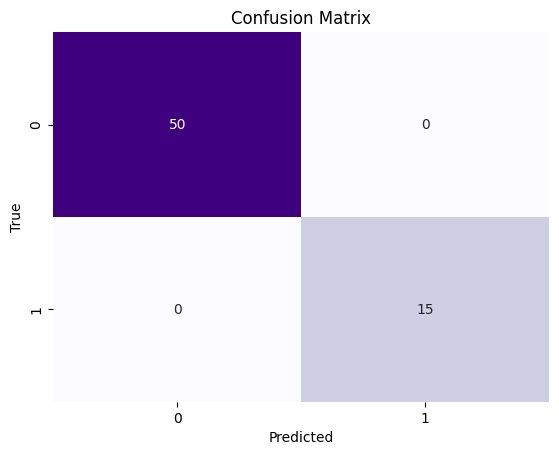

In [22]:
cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Random Forest

In [23]:
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(random_state=42)
random_forest_model.fit(X_train_resampled, y_train_resampled)
y_pred_rf = random_forest_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

random_forest_model.score(X_train_resampled, y_train_resampled), random_forest_model.score(X_test, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        15

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



(1.0, 1.0)

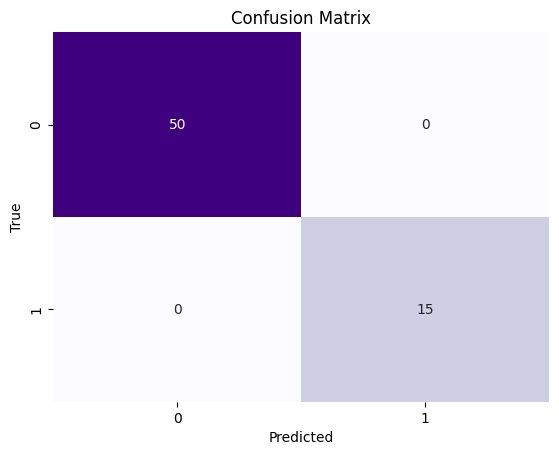

In [24]:
cm = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# SVM

In [25]:
from sklearn.svm import SVC

svm_model = SVC(random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)
y_pred_svm = svm_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

svm_model.score(X_train_resampled, y_train_resampled), svm_model.score(X_test, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.58      0.72        50
           1       0.40      0.93      0.56        15

    accuracy                           0.66        65
   macro avg       0.68      0.76      0.64        65
weighted avg       0.84      0.66      0.69        65



(0.6164021164021164, 0.6615384615384615)

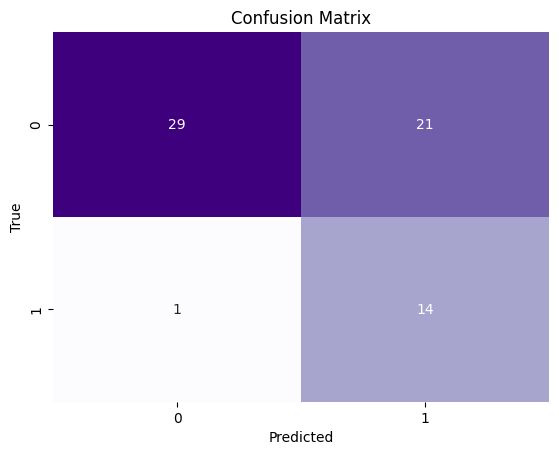

In [26]:
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
knn_model.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn_model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

knn_model.score(X_train_resampled, y_train_resampled), knn_model.score(X_test, y_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.78      0.85        50
           1       0.52      0.80      0.63        15

    accuracy                           0.78        65
   macro avg       0.73      0.79      0.74        65
weighted avg       0.83      0.78      0.80        65



(0.8465608465608465, 0.7846153846153846)

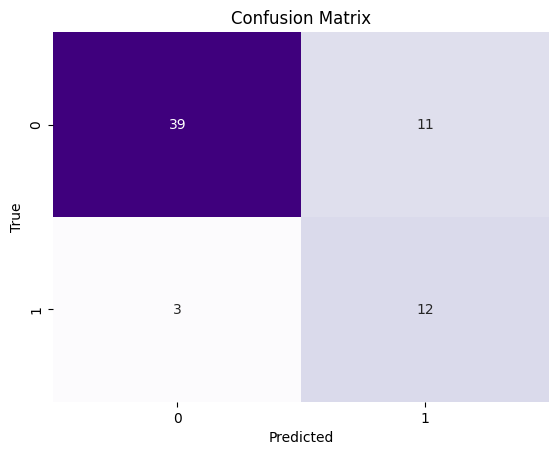

In [28]:
cm = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# XGBOOST

In [29]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred_xgb = xgb_model.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

xgb_model.score(X_train_resampled, y_train_resampled), xgb_model.score(X_test, y_test)


Confusion Matrix:
[[50  0]
 [ 0 15]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        15

    accuracy                           1.00        65
   macro avg       1.00      1.00      1.00        65
weighted avg       1.00      1.00      1.00        65



(1.0, 1.0)

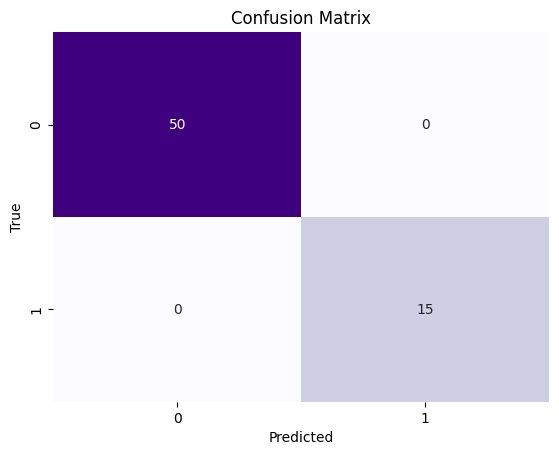

In [30]:
cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='g', cmap='Purples', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Decision Region

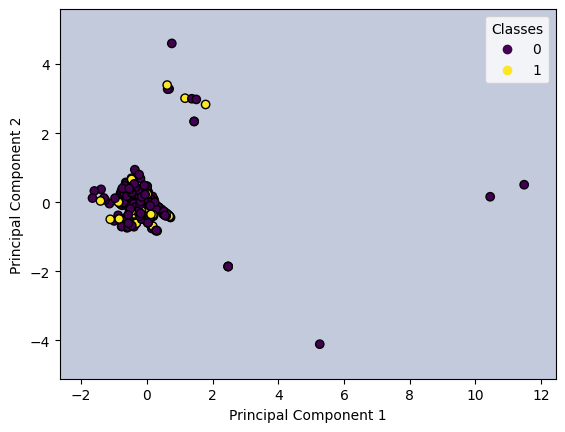

In [31]:
# Assuming X contains your feature matrix, and y contains your target variable
X_selected = X[['LATITUDE', 'LONGITUDE']]
y_selected = y

# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_selected_std = scaler.fit_transform(X_train_selected)
X_test_selected_std = scaler.transform(X_test_selected)

# Reduce dimensionality for visualization
pca = PCA(n_components=2)
X_train_selected_pca = pca.fit_transform(X_train_selected_std)

# Train your classifier (replace YourClassifier with your actual classifier)
clf = LogisticRegression()
clf.fit(X_train_selected_std, y_train_selected)

# Plot decision regions
x_min, x_max = X_train_selected_pca[:, 0].min() - 1, X_train_selected_pca[:, 0].max() + 1
y_min, y_max = X_train_selected_pca[:, 1].min() - 1, X_train_selected_pca[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision regions
plt.contourf(xx, yy, Z, alpha=0.3)

# Scatter plot for training data with different classes
scatter = plt.scatter(X_train_selected_pca[:, 0], X_train_selected_pca[:, 1], c=y_train_selected, marker='o', edgecolors='k', label='Training Data')

# Add legend
legend = plt.legend(*scatter.legend_elements(), title='Classes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()
